## **Trabajo Práctico Integrador**
Realizado por Brisa Antuña Bianchi, Sofía Escudero y Nael Pighin.

# **Librerías**

In [ ]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import sys
import imutils
from ipywidgets import interact, IntSlider, FloatSlider, RadioButtons, Checkbox

print("Python version %s / OpenCV version %s " %(sys.version,cv.__version__))

Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] / OpenCV version 4.8.0 


Activo mi entorno GDrive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# versión rotada

## parte de segmentación

In [ ]:
# Función para aplicar la corrección de sombras
def eliminar_sombras(imagen_bgr):
    # Convertir la imagen al espacio de color HSV
    imagen_hsv = cv.cvtColor(imagen_bgr, cv.COLOR_BGR2HSV)
    h, s, v = cv.split(imagen_hsv)

    # Aplicar la corrección de sombras en el canal de value (V)
    v_log = np.log1p(v.astype(np.float32)) #Calculo el logaritmo de la componente de value para aumentar el rango del value claro y disminuir el oscuro
    v_log_blurred = cv.GaussianBlur(v_log, (29, 29), 0) #Aplico un filtro de desenfoque para eliminar los detalles finos como las sombras
    v_log_shadow_removed = v_log - v_log_blurred #Resto la imagen desenfocada a la imagen original, para quedarme solo con los detalles importantes
    v_shadow_removed = np.expm1(v_log_shadow_removed) # vuelvo a la distribucion original de value

    # Normalizar el canal de luminosidad corregido
    v_shadow_removed = cv.normalize(v_shadow_removed, None, 0, 255, cv.NORM_MINMAX)
    v_shadow_removed = np.uint8(v_shadow_removed)

    # Recombinar los canales H, S y V corregido
    imagen_hsv_corrected = cv.merge([h, s, v_shadow_removed])

    # Convertir de nuevo al espacio de color RGB
    imagen_rgb_corrected = cv.cvtColor(imagen_hsv_corrected, cv.COLOR_HSV2BGR)

    return imagen_rgb_corrected

In [ ]:
def recorte_a_placa(image):
    # Bordes con Canny
    image_sin_sombras = eliminar_sombras(image)
    gray_image = cv.cvtColor(image_sin_sombras, cv.COLOR_BGR2GRAY)
    blurred_image = cv.GaussianBlur(gray_image, (11,11), 0)
    edges = cv.Canny(blurred_image, 20, 20, L2gradient=False)

    # Aplicar operaciones morfológicas para cerrar gaps
    kernel = np.ones((18,18), np.uint8)
    edges2 = cv.morphologyEx(edges, cv.MORPH_CLOSE, kernel)

    # Encontrar contornos
    contours, _ = cv.findContours(edges2, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Asumiendo que tenemos un contorno dominante (el del rectángulo rotado)
    contour = max(contours, key=cv.contourArea)

    # Encontrar el rectángulo de área mínima que circunscribe el contorno
    rect = cv.minAreaRect(contour)

    # Obtener los vértices del rectángulo
    box = cv.boxPoints(rect)
    box = np.intp(box)

    # Corregir ángulo de la imagen
    dx = box[1][0] - box[0][0]
    dy = box[1][1] - box[0][1]
    angle = np.degrees(np.arctan2(dy, dx))

    # ajustes p/ q quede horizontal
    if angle < -45:
        angle += 90
    elif angle > 45:
        angle -= 90

    # Obtener el centro de la imagen
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)

    # Crear la matriz de rotación
    M = cv.getRotationMatrix2D(center, angle, 1.0)

    # Aplicar la rotación a la imagen
    rotated_image = cv.warpAffine(image, M, (w, h))

    # Rotar las coordenadas del rectángulo
    rotated_vertices = np.dot(box - center, M[:, :2].T) + center

    # Encontrar el bounding box del rectángulo rotado
    x, y, w, h = cv.boundingRect(rotated_vertices.astype(np.int32))

    # Recortar la imagen usando el bounding box
    cropped_image = rotated_image[y:y+h, x:x+w]

    return cropped_image

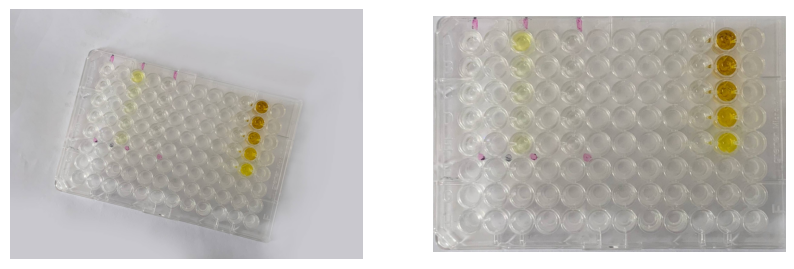

In [ ]:
image = cv.imread('/content/drive/My Drive/imagenes elisa/ejemplo_rotado.jpg')

cropped_image = recorte_a_placa(image)

fig, ax = plt.subplots(1,2,figsize=(10,10))
ax[0].imshow(image[:,:,[2,1,0]])
ax[0].axis('off')
ax[1].imshow(cropped_image[:,:,[2,1,0]])
ax[1].axis('off')
plt.show()

In [ ]:
def reducir_bordes_porcentaje(imagen):
  porcental_x = 77/1206
  porcental_y = 49/792

  H, W, _ = imagen.shape
  bordes_H = int(H*porcental_y)
  bordes_W = int(W*porcental_x)
  fin_H = H - bordes_H
  fin_W = W - bordes_W

  return imagen[bordes_H:fin_H,bordes_W:fin_W]

In [ ]:
def aumentar_resolucion(imagen):
  return cv.resize(imagen, (2880, 1920))

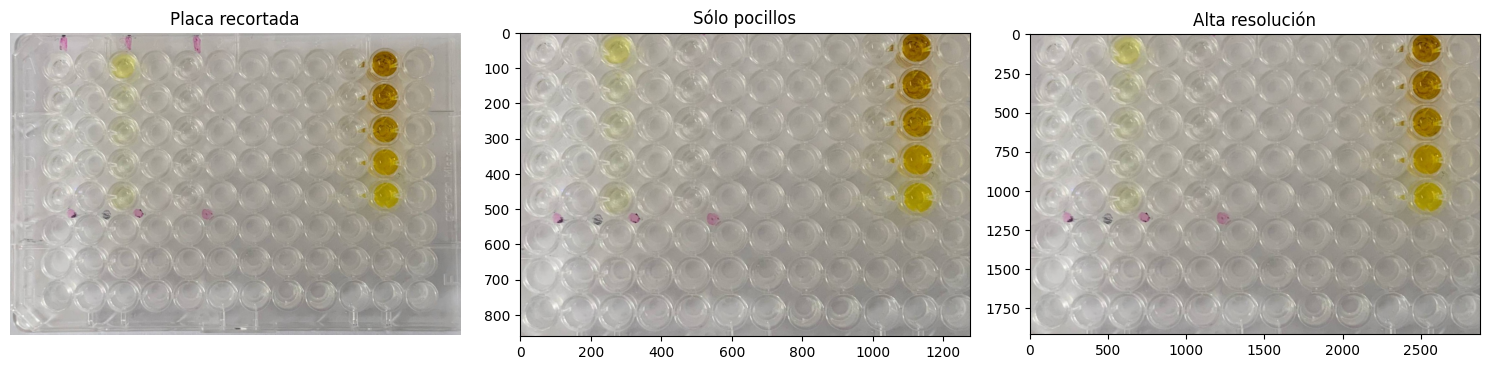

In [ ]:
imagen_crop = cropped_image.copy()
imagen_bordes_reducidos = reducir_bordes_porcentaje(imagen_crop)
imagen_high_res = aumentar_resolucion(imagen_bordes_reducidos)

fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(imagen_crop[:,:,[2,1,0]])
ax[0].axis('off')
ax[0].set_title('Placa recortada')
ax[1].imshow(imagen_bordes_reducidos[:,:,[2,1,0]])
ax[1].set_title('Sólo pocillos')
ax[2].imshow(imagen_high_res[:,:,[2,1,0]])
ax[2].set_title('Alta resolución')
plt.tight_layout()
plt.show()

In [ ]:
def detectar_circulos(image):
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    blurred_image = cv.GaussianBlur(gray_image, (5, 5), 0)
    circles = cv.HoughCircles(blurred_image, cv.HOUGH_GRADIENT, dp=2.5, minDist=207, param1=23, param2=11, minRadius=100, maxRadius=100)
    pocillos = []
    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for circle in circles:
            x, y, r = circle
            pocillos.append((x, y, r))
    return pocillos

In [ ]:
def recortar_por_circulos_externos(imagen, pocillos):

    n_imagen_recortada = imagen.copy()

    # Encontrar los límites de recorte basados en los círculos detectados
    min_x = min(x - r for x, y, r in pocillos)
    max_x = max(x + r for x, y, r in pocillos)
    min_y = min(y - r for x, y, r in pocillos)
    max_y = max(y + r for x, y, r in pocillos)

    # Asegurarse de que los límites están dentro del tamaño de la imagen
    min_x = max(min_x, 0)
    max_x = min(max_x, n_imagen_recortada.shape[1])
    min_y = max(min_y, 0)
    max_y = min(max_y, n_imagen_recortada.shape[0])

    # Actualizar las coordenadas de los círculos detectados después del recorte
    pocillos2 = [(x - min_x, y - min_y, r) for x, y, r in pocillos]
    n_imagen_recortada = n_imagen_recortada[min_y:max_y, min_x:max_x]

    return n_imagen_recortada, pocillos2

In [ ]:
def graficar_circulos(image, pocillos):
    imagen_con_circulos = image.copy()
    for (x, y, r) in pocillos:
        cv.circle(imagen_con_circulos, (x, y), r, (127, 0, 255), 4)
    return imagen_con_circulos

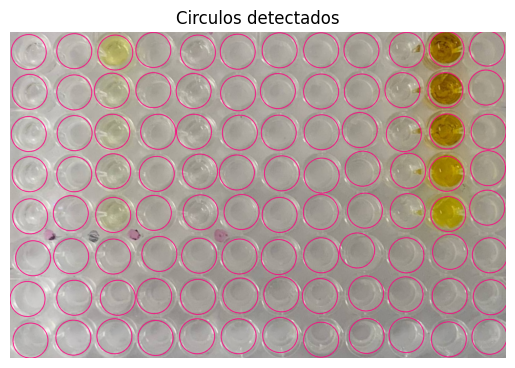

In [ ]:
imagen = imagen_high_res.copy()

pocillos = detectar_circulos(imagen)

n_imagen_recortada, pocillos = recortar_por_circulos_externos(imagen, pocillos)

imagen_con_circulos = graficar_circulos(n_imagen_recortada, pocillos)

plt.imshow(imagen_con_circulos[:,:,[2,1,0]])
plt.title('Circulos detectados')
plt.axis('off')
plt.show()

In [ ]:
def completar_pocillos(radio, lista_pocillos, tolerancia, ancho, alto):
    # Inicializar la matriz de círculos teóricos para almacenar las coordenadas
    circulos_teoricos = [[[0, 0] for _ in range(8)] for _ in range(12)]

    # Calcular los espaciados horizontal y vertical entre los círculos
    h_ancho = (ancho - (12 * 2 * radio)) / 13
    h_alto = (alto - (8 * 2 * radio)) / 9

    # Calcular las coordenadas de los centros de los círculos
    for i in range(12):
        for j in range(8):
            circulos_teoricos[i][j][0] = radio + (2 * radio + h_ancho) * i + h_ancho
            circulos_teoricos[i][j][1] = radio + (2 * radio + h_alto) * j + h_alto

    # Listas para almacenar los círculos correctos e incorrectos
    circulos_correctos = []
    circulos_incorrectos = []

    # Comparar los círculos detectados con la matriz de referencia
    for i in range(12):
        for j in range(8):
            centro_x, centro_y = circulos_teoricos[i][j]
            coincidencia = False
            for (x, y, r) in lista_pocillos:
                if abs(x - centro_x) <= tolerancia and abs(y - centro_y) <= tolerancia:
                    circulos_correctos.append((int(x), int(y), int(r)))
                    coincidencia = True
                    break
            if not coincidencia:
                circulos_incorrectos.append((int(centro_x), int(centro_y), int(radio)))

    return circulos_teoricos, circulos_correctos, circulos_incorrectos

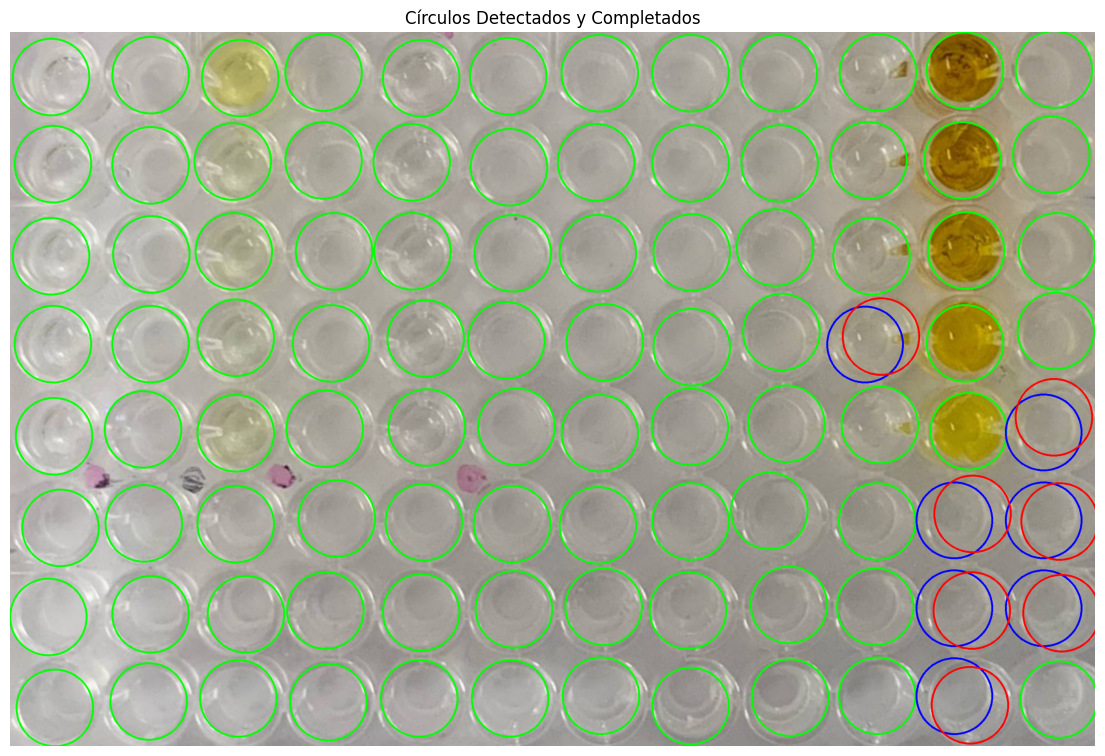

In [ ]:
ancho = n_imagen_recortada.shape[1]
alto = n_imagen_recortada.shape[0]

radio = 100
tolerancia = 40  # Ajustar según sea necesario

centros_detectados = [(x, y, r) for x, y, r in pocillos]
circulos_teoricos, circulos_correctos, circulos_incorrectos = completar_pocillos(radio, centros_detectados, tolerancia, ancho, alto)

# Identificar los círculos reales que no coincidieron
circulos_reales_incorrectos = []
for (x, y, r) in centros_detectados:
    if not any(abs(x - cx) <= tolerancia and abs(y - cy) <= tolerancia for cx, cy, cr in circulos_correctos):
        circulos_reales_incorrectos.append((x, y, r))

# Graficar los resultados sobre la imagen
imagen_resultado = n_imagen_recortada.copy()

# Dibujar los círculos correctos en verde
for (x, y, r) in circulos_correctos:
    cv.circle(imagen_resultado, (x, y), r, (0, 255, 0), 4)

# Dibujar los círculos teóricos incorrectos en azul
for (x, y, r) in circulos_incorrectos:
    cv.circle(imagen_resultado, (x, y), r, (255, 0, 0), 4)

# Dibujar los círculos reales incorrectos en rojo
for (x, y, r) in circulos_reales_incorrectos:
    cv.circle(imagen_resultado, (x, y), r, (0, 0, 255), 4)

plt.figure(figsize=(14, 10))
plt.imshow(cv.cvtColor(imagen_resultado, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Círculos Detectados y Completados')
plt.show()

In [ ]:
print('Círculos correctos:',len(circulos_correctos))
print('Círculos incorrectos:',len(circulos_incorrectos))

Círculos correctos: 89
Círculos incorrectos: 7


## parte de color

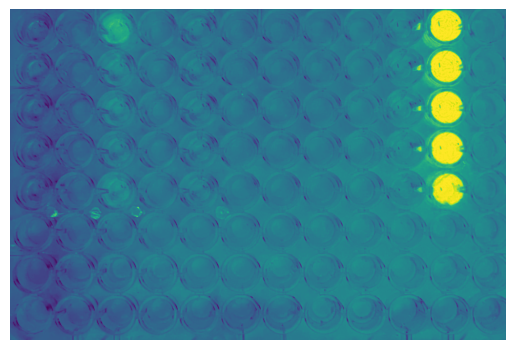

In [ ]:
B, G, R = cv.split(imagen)

canal_amarillo = 255 - B

canal_amarillo = cv.normalize(canal_amarillo, None, 0, 255, cv.NORM_MINMAX)

canal_amarillo = np.uint8(canal_amarillo)

plt.imshow(canal_amarillo)
plt.axis('off')
plt.show()

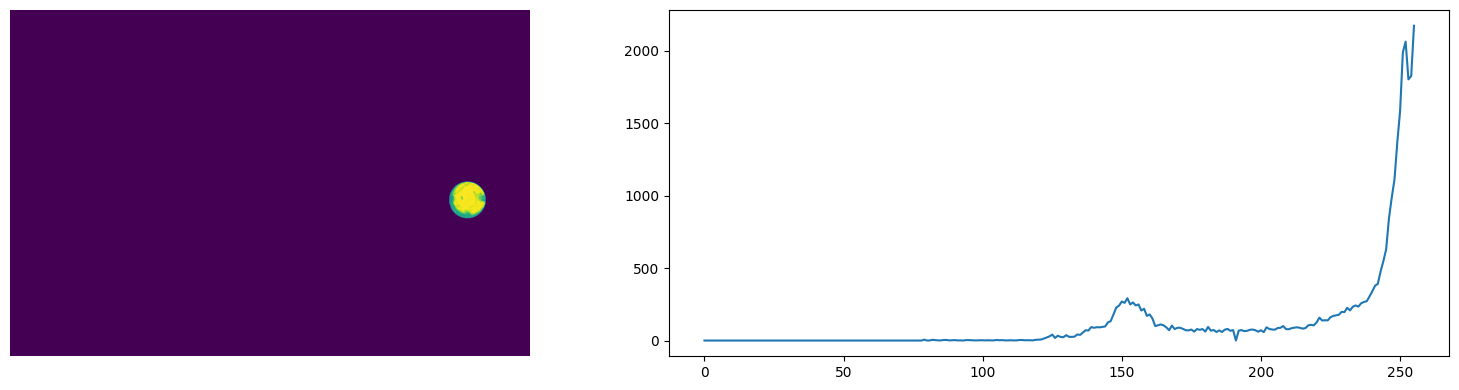

In [ ]:
canal_amarillo2 = canal_amarillo.copy()

for i in range(96):
  centro = centros_detectados[i]
  x,y = (2400,1000)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break

x,y,r = centros_detectados[i]

mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)

mask_canal = cv.bitwise_and(canal_amarillo2, canal_amarillo2, mask=mask)
hist = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(mask_canal,vmin=0,vmax=255)
ax[0].axis('off')
ax[1].plot(hist)
plt.tight_layout()
plt.show()

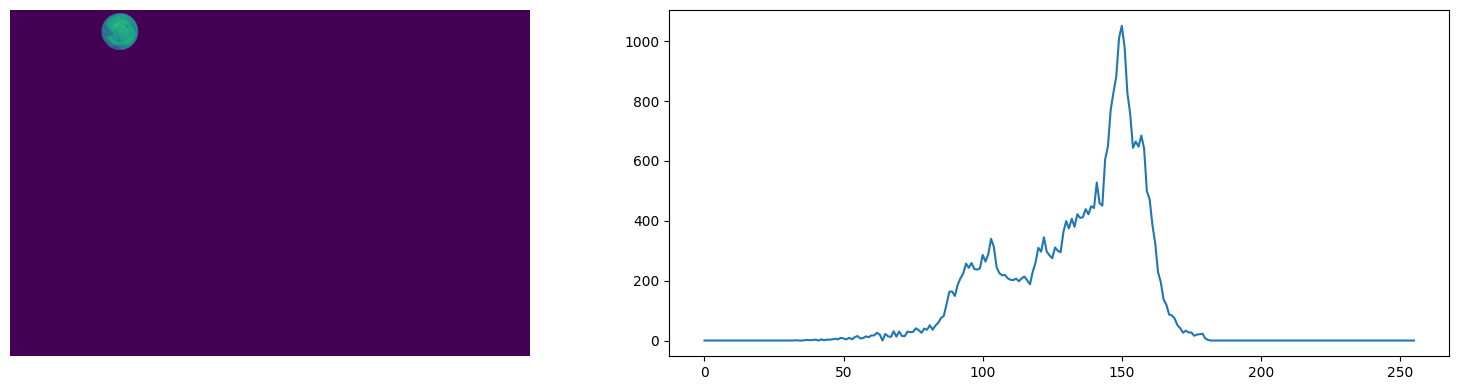

In [ ]:
canal_amarillo2 = canal_amarillo.copy()

for i in range(96):
  centro = centros_detectados[i]
  x,y = (600,120)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break
x,y,r = centros_detectados[i]

mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)

mask_canal = cv.bitwise_and(canal_amarillo2, canal_amarillo2, mask=mask)
hist2 = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(mask_canal,vmin=0,vmax=255)
ax[0].axis('off')
ax[1].plot(hist2)
plt.tight_layout()
plt.show()

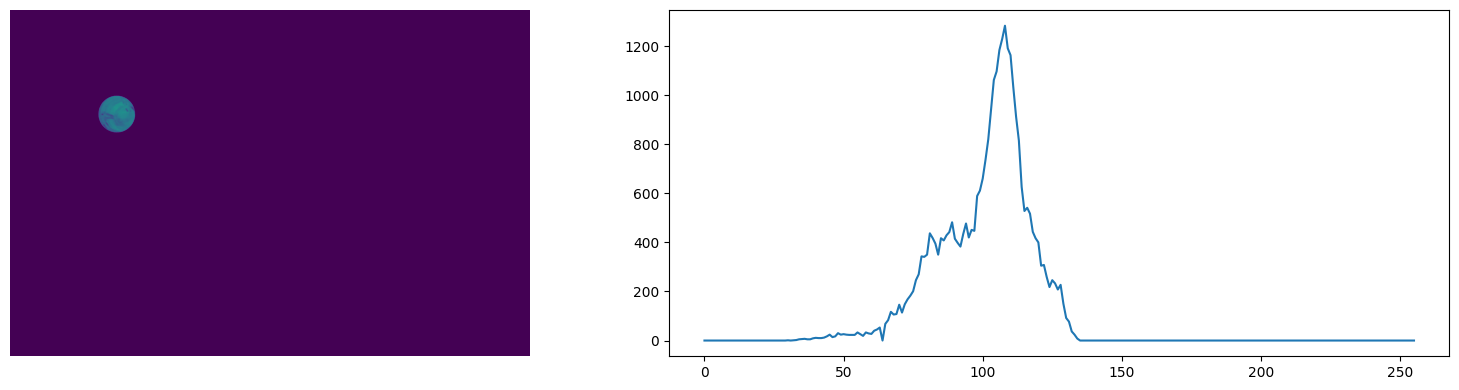

In [ ]:
canal_amarillo2 = canal_amarillo.copy()

for i in range(96):
  centro = centros_detectados[i]
  x,y = (600,600)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break
x,y,r = centros_detectados[i]

mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)

mask_canal = cv.bitwise_and(canal_amarillo2, canal_amarillo2, mask=mask)
hist3 = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(mask_canal,vmin=0,vmax=255)
ax[0].axis('off')
ax[1].plot(hist3)
plt.tight_layout()
plt.show()

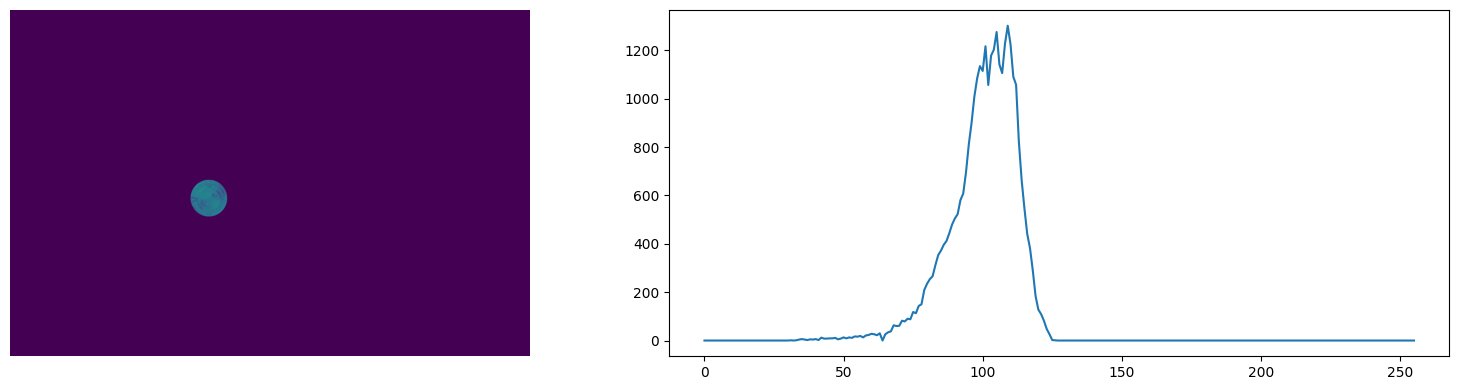

In [ ]:
canal_amarillo2 = canal_amarillo.copy()

for i in range(96):
  centro = centros_detectados[i]
  x,y = (1100,1050)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break
x,y,r = centros_detectados[i]

mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)

mask_canal = cv.bitwise_and(canal_amarillo2, canal_amarillo2, mask=mask)
hist4 = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

fig,ax = plt.subplots(1,2,figsize=(16,4))
ax[0].imshow(mask_canal,vmin=0,vmax=255)
ax[0].axis('off')
ax[1].plot(hist4)
plt.tight_layout()
plt.show()

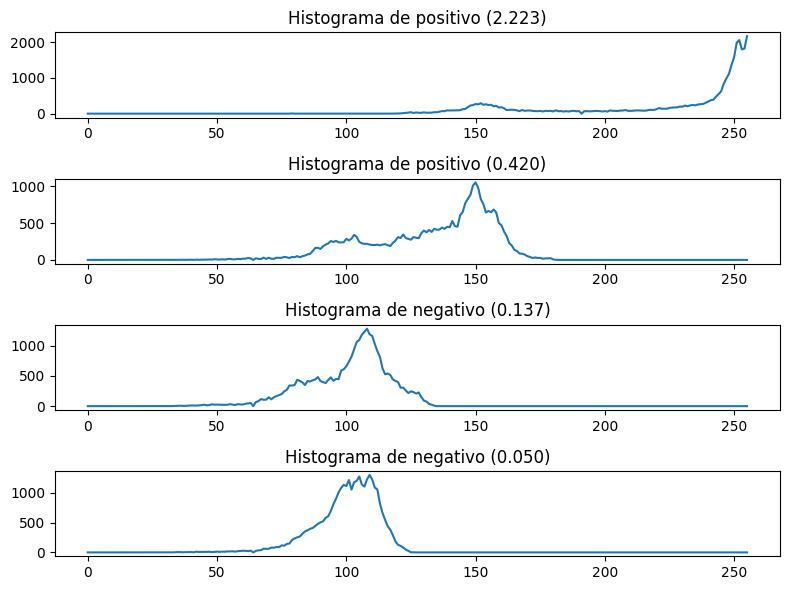

In [ ]:
fig,ax = plt.subplots(4,1,figsize=(8,6))

ax[0].plot(hist)
ax[0].set_title('Histograma de positivo (2.223)')
ax[1].plot(hist2)
ax[1].set_title('Histograma de positivo (0.420)')
ax[2].plot(hist3)
ax[2].set_title('Histograma de negativo (0.137)')
ax[3].plot(hist4)
ax[3].set_title('Histograma de negativo (0.050)')
plt.tight_layout()
plt.show()

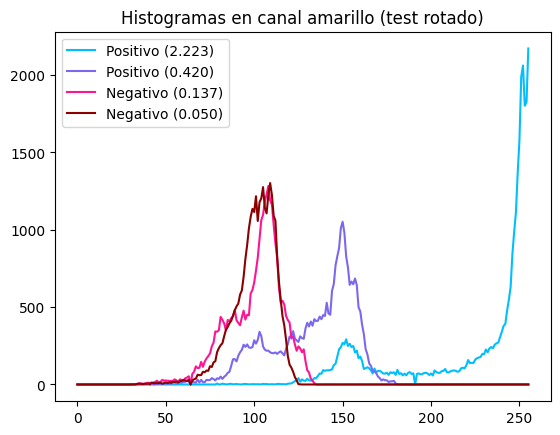

In [ ]:
plt.plot(hist, color='deepskyblue', label='Positivo (2.223)')
plt.plot(hist2, color='mediumslateblue', label='Positivo (0.420)')
plt.plot(hist3, color='deeppink', label='Negativo (0.137)')
plt.plot(hist4, color='darkred', label='Negativo (0.050)')
plt.legend()
plt.title('Histogramas en canal amarillo (test rotado)')
plt.show()

# versión con flash

## parte de segmentación

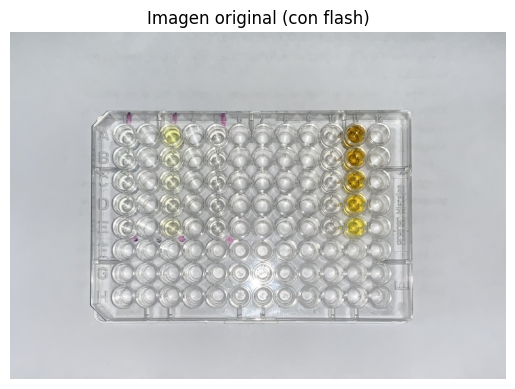

In [ ]:
image = cv.imread('/content/drive/My Drive/imagenes elisa/IMG_9635.jpg')

plt.imshow(image[:,:,[2,1,0]])
plt.title("Imagen original (con flash)")
plt.axis('off')
plt.show()

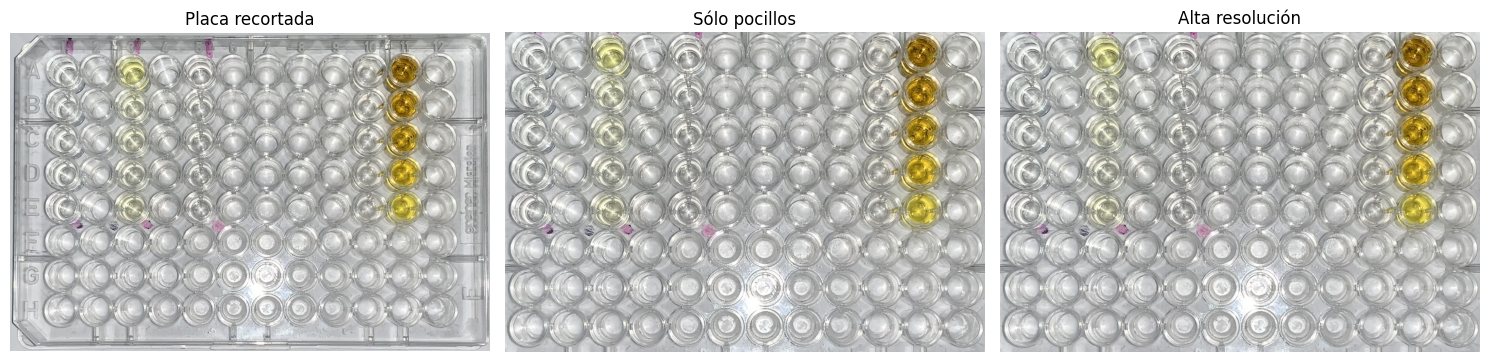

In [ ]:
cropped_image = recorte_a_placa(image)
imagen_crop = cropped_image.copy()
imagen_bordes_reducidos = reducir_bordes_porcentaje(imagen_crop)
imagen_high_res = aumentar_resolucion(imagen_bordes_reducidos)

fig, ax = plt.subplots(1,3,figsize=(15,15))
ax[0].imshow(imagen_crop[:,:,[2,1,0]])
ax[0].axis('off')
ax[0].set_title('Placa recortada')
ax[1].imshow(imagen_bordes_reducidos[:,:,[2,1,0]])
ax[1].axis('off')
ax[1].set_title('Sólo pocillos')
ax[2].imshow(imagen_high_res[:,:,[2,1,0]])
ax[2].axis('off')
ax[2].set_title('Alta resolución')
plt.tight_layout()
plt.show()

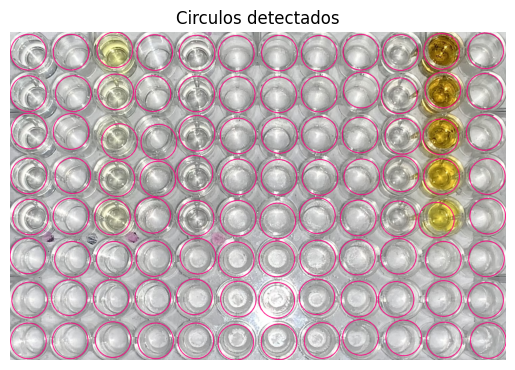

In [ ]:
imagen = imagen_high_res.copy()

pocillos = detectar_circulos(imagen)

n_imagen_recortada, pocillos = recortar_por_circulos_externos(imagen, pocillos)

imagen_con_circulos = graficar_circulos(n_imagen_recortada, pocillos)

plt.imshow(imagen_con_circulos[:,:,[2,1,0]])
plt.title('Circulos detectados')
plt.axis('off')
plt.show()

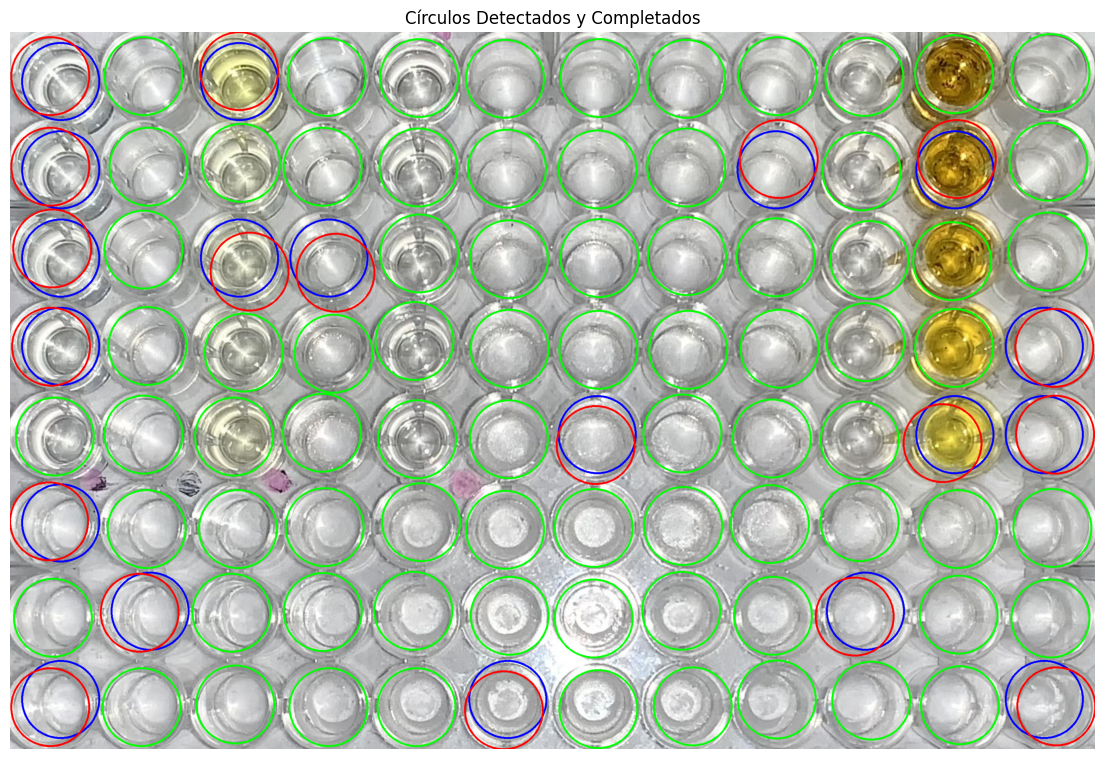

In [ ]:
ancho = n_imagen_recortada.shape[1]
alto = n_imagen_recortada.shape[0]

radio = 100
tolerancia = 25  # Ajustar según sea necesario

centros_detectados = [(x, y, r) for x, y, r in pocillos]
circulos_teoricos, circulos_correctos, circulos_incorrectos = completar_pocillos(radio, centros_detectados, tolerancia, ancho, alto)

# Identificar los círculos reales que no coincidieron
circulos_reales_incorrectos = []
for (x, y, r) in centros_detectados:
    if not any(abs(x - cx) <= tolerancia and abs(y - cy) <= tolerancia for cx, cy, cr in circulos_correctos):
        circulos_reales_incorrectos.append((x, y, r))

# Graficar los resultados sobre la imagen
imagen_resultado = n_imagen_recortada.copy()

# Dibujar los círculos correctos en verde
for (x, y, r) in circulos_correctos:
    cv.circle(imagen_resultado, (x, y), r, (0, 255, 0), 4)

# Dibujar los círculos teóricos incorrectos en azul
for (x, y, r) in circulos_incorrectos:
    cv.circle(imagen_resultado, (x, y), r, (255, 0, 0), 4)

# Dibujar los círculos reales incorrectos en rojo
for (x, y, r) in circulos_reales_incorrectos:
    cv.circle(imagen_resultado, (x, y), r, (0, 0, 255), 4)

plt.figure(figsize=(14, 10))
plt.imshow(cv.cvtColor(imagen_resultado, cv.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Círculos Detectados y Completados')
plt.show()

In [ ]:
print('Círculos correctos:',len(circulos_correctos))
print('Círculos incorrectos:',len(circulos_incorrectos))

Círculos correctos: 77
Círculos incorrectos: 19


## parte de color

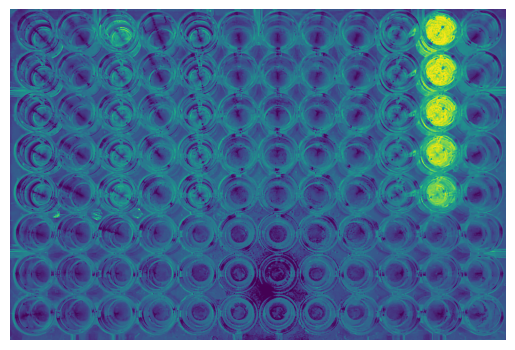

In [ ]:
B, G, R = cv.split(imagen)

canal_amarillo = 255 - B

canal_amarillo = cv.normalize(canal_amarillo, None, 0, 255, cv.NORM_MINMAX)

canal_amarillo = np.uint8(canal_amarillo)

plt.imshow(canal_amarillo)
plt.axis('off')
plt.show()

In [ ]:
canal_amarillo2 = canal_amarillo.copy()

# POSITIVO EVIDENTE
for i in range(96):
  centro = centros_detectados[i]
  x,y = (2500,1000)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break
x,y,r = centros_detectados[i]
mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)
hist = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

# POSITIVO NO EVIDENTE
for i in range(96):
  centro = centros_detectados[i]
  x,y = (600,120)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break
x,y,r = centros_detectados[i]
mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)
hist2 = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

# NEGATIVO NO EVIDENTE
for i in range(96):
  centro = centros_detectados[i]
  x,y = (600,600)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break
x,y,r = centros_detectados[i]
mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)
hist3 = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

# NEGATIVO EVIDENTE
for i in range(96):
  centro = centros_detectados[i]
  x,y = (1100,1050)
  if (np.abs(x-centro[0])+np.abs(y-centro[1])) < 200:
    break
x,y,r = centros_detectados[i]
mask = np.zeros(canal_amarillo2.shape[:2], dtype=np.uint8)
cv.circle(mask, (x,y), r, (255), thickness=-1)
hist4 = cv.calcHist([canal_amarillo2], [0], mask, [256], [0, 256])

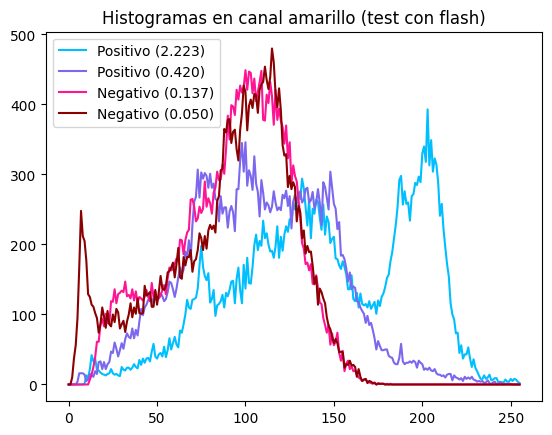

In [ ]:
plt.plot(hist, color='deepskyblue', label='Positivo (2.223)')
plt.plot(hist2, color='mediumslateblue', label='Positivo (0.420)')
plt.plot(hist3, color='deeppink', label='Negativo (0.137)')
plt.plot(hist4, color='darkred', label='Negativo (0.050)')
plt.legend()
plt.title('Histogramas en canal amarillo (test con flash)')
plt.show()